In [1]:
import numpy as np
import pandas as pd
import pystan
import matplotlib.pyplot as plt
import random
import time
%matplotlib inline

In [2]:
def logit(z): return 1./(1.+np.exp(-z))

In [3]:
def generate_players(num_of_players, skill_cap):
    ## returns a list of player's skill
    return [round(random.uniform(0,skill_cap),2) for i in range(num_of_players)]

In [4]:
def generate_games_for_new_player(true_players, new_player, num_of_games,scale, style='pygm'):
    p1_list=[]
    p2_list=[]
    win_list=[]
    for i in range(num_of_games):
        p1 = len(true_players)+1
        p2 = random.sample(range(1,len(true_players)+1),1)[0]
        win_rate = logit (scale* (new_player- true_players[p2-1]))
        
        p1_list.append(p1)
        p2_list.append(p2)
        win_list.append(*random.choices([1,0],weights=[win_rate, 1-win_rate]))
#         games.append((p1,p2,*random.choices([1,-1],weights=[win_rate, 1-win_rate])))

    return p1_list, p2_list, win_list

In [34]:
def create_skill_model(skills):
    model = """
data {
  int<lower=1> N;             # Total number of players
  int<lower=1> E;             # number of games
  real<lower=0> scale;        # scale value for probability computation
  int<lower=0,upper=1> win[E]; # PA wins vs PB
  int PA[E];                  # player info between each game
  int PB[E];                  # 
}
parameters {
  vector [N] skill;           # skill values for each player
}

model{
"""
    for i in range(1, len(skills)+1):
        model += f"skill[{i}]~normal({skills[i-1]}, 3);\n"
    model += f"skill[{len(skills)+1}]~normal(25,10);\n"
    model += """for (i in 1:E){ 
    win[i] ~ bernoulli_logit( (scale)*(skill[PA[i]]-skill[PB[i]]) ); 
  }   # win probability is a logit function of skill difference 
}"""
    return model

In [6]:
true_players=generate_players(10,50)
skill_model = create_skill_model(true_players)

In [7]:
import pickle

sm = pystan.StanModel(model_code = skill_model)
#with open('skill_model_test.pkl', 'wb') as f: pickle.dump(sm, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f7da18d307891872d2855febe1643eb0 NOW.


In [8]:
skill_model

'\ndata {\n  int<lower=1> N;             # Total number of players\n  int<lower=1> E;             # number of games\n  real<lower=0> scale;        # scale value for probability computation\n  int<lower=0,upper=1> win[E]; # PA wins vs PB\n  int PA[E];                  # player info between each game\n  int PB[E];                  # \n}\nparameters {\n  vector [N] skill;           # skill values for each player\n}\n\nmodel{\nskill[1]~normal(41.21, 3);\nskill[2]~normal(12.9, 3);\nskill[3]~normal(2.34, 3);\nskill[4]~normal(10.09, 3);\nskill[5]~normal(21.78, 3);\nskill[6]~normal(12.11, 3);\nskill[7]~normal(3.1, 3);\nskill[8]~normal(2.81, 3);\nskill[9]~normal(23.5, 3);\nskill[10]~normal(2.44, 3);\nskill[11]~normal(25,8);\nfor (i in 1:E){ \n    win[i] ~ bernoulli_logit( (scale)*(skill[PA[i]]-skill[PB[i]]) ); \n  }   # win probability is a logit function of skill difference \n}'

In [9]:
new_player = round(random.uniform(0,50),2)

In [10]:
num_of_games = 20
scale = 0.5
p1_list,p2_list,win_list = generate_games_for_new_player(true_players, new_player, num_of_games,scale )

In [11]:
len(p1_list), len(p2_list)

[11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11]

In [13]:
win_list

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [14]:
skill_data = {
    'N': len(true_players) + 1,
    'E': num_of_games,
    'scale': 0.5,
    'win':win_list,
    'PA': p1_list,
    'PB': p2_list,
}

In [15]:
fit = sm.sampling(data=skill_data, iter=200, chains=2)

In [16]:
samples = fit.extract()

In [21]:
samples['skill'].mean(0)

array([38.92907177, 12.85365802,  2.6025486 , 10.30073679, 21.92964736,
       12.1198313 ,  3.08185213,  2.85486205, 23.56666353,  2.30696619,
       42.16616524])

In [18]:
true_players

[41.21, 12.9, 2.34, 10.09, 21.78, 12.11, 3.1, 2.81, 23.5, 2.44]

In [19]:
new_player

46.05

# Compare

In [1]:
import numpy as np
import pandas as pd
import pystan
import matplotlib.pyplot as plt
import random
import time
%matplotlib inline
import pickle

In [2]:
def logit(z): return 1./(1.+np.exp(-z))

def generate_players(num_of_players, skill_cap):
    ## returns a list of player's skill
    return [round(random.uniform(0,skill_cap),2) for i in range(num_of_players)]

def generate_games_for_new_player(true_players, new_player, num_of_games,scale, style='pygm'):
    p1_list=[]
    p2_list=[]
    win_list=[]
    for i in range(num_of_games):
        p1 = len(true_players)+1
        p2 = random.sample(range(1,len(true_players)+1),1)[0]
        win_rate = logit (scale* (new_player- true_players[p2-1]))
        
        p1_list.append(p1)
        p2_list.append(p2)
        win_list.append(*random.choices([1,0],weights=[win_rate, 1-win_rate]))
#         games.append((p1,p2,*random.choices([1,-1],weights=[win_rate, 1-win_rate])))

    return p1_list, p2_list, win_list

In [3]:
def create_skill_model(skills, mean, std, fixed_std = 3):
    model = """
data {
  int<lower=1> N;             # Total number of players
  int<lower=1> E;             # number of games
  real<lower=0> scale;        # scale value for probability computation
  int<lower=0,upper=1> win[E]; # PA wins vs PB
  int PA[E];                  # player info between each game
  int PB[E];                  # 
}
parameters {
  vector [N] skill;           # skill values for each player
}

model{
"""
    for i in range(1, len(skills)+1):
        model += f"skill[{i}]~normal({skills[i-1]}, {fixed_std});\n"
    model += f"skill[{len(skills)+1}]~normal({mean},{std});\n"
    model += """for (i in 1:E){ 
    win[i] ~ bernoulli_logit( (scale)*(skill[PA[i]]-skill[PB[i]]) ); 
  }   # win probability is a logit function of skill difference 
}"""
    return model

In [53]:
def compare_ngames(n_games_range, iter = 10, n_players = 10, skill_cap = 50, scale = 0.5):
    true_players=generate_players(n_players, skill_cap)
    mean = round(skill_cap / 2)
    std = round(mean / 3)
    skill_model = create_skill_model(true_players, mean, 10)
    #print(skill_model)
    sm = pystan.StanModel(model_code = skill_model)
    
    new_player = round(random.uniform(0,skill_cap),2)
    print(true_players)
    
    result = {}
    
    for num_of_games in n_games_range:
        print(num_of_games, new_player)
        diffs = []
        for _ in range(iter):
            p1_list,p2_list,win_list = generate_games_for_new_player(true_players, new_player, num_of_games, scale)
            skill_data = {
                'N': len(true_players) + 1,
                'E': num_of_games,
                'scale': 0.5,
                'win':win_list,
                'PA': p1_list,
                'PB': p2_list,
            }
            fit = sm.sampling(data=skill_data, iter=400, chains=2, control={'max_treedepth': 14})
            samples = fit.extract()

            pred = samples['skill'].mean(0)[-1]
            diff = abs(pred - new_player)**2
            #print(f'pred:{pred}, diff:{diff}')
            print('*',end='')
            
            diffs.append(diff)
        result[num_of_games] = diffs
        print('mean:',np.mean(diffs), '\n')
    return result

In [56]:
result = compare_ngames(range(10, 101, 15), iter = 10, n_players = 50, skill_cap = 50)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_eff36563b5a2fbc2e9b4814244d57166 NOW.


[5.11, 29.41, 2.07, 17.09, 45.35, 16.22, 10.39, 46.38, 37.88, 30.2, 31.53, 5.76, 16.11, 24.23, 35.4, 38.37, 17.94, 13.85, 27.09, 30.71, 48.44, 22.02, 44.3, 6.02, 42.0, 36.61, 48.55, 42.86, 29.79, 4.35, 11.32, 1.86, 37.87, 38.33, 3.2, 38.07, 22.57, 22.57, 6.7, 48.15, 9.36, 39.64, 21.3, 32.23, 16.34, 7.59, 12.31, 47.05, 41.79, 20.25]
10 42.26
**********mean: 20.704616064544826 

25 42.26
**********mean: 5.2225649427869545 

40 42.26
**********mean: 4.3079514013172115 

55 42.26
**********mean: 2.4063466702291483 

70 42.26
**********mean: 1.2014329392844938 

85 42.26
**********mean: 1.655875050188038 

100 42.26
**********mean: 1.1948373423897882 



[10, 25, 40, 55, 70, 85, 100]
[10.868188115522695, 4.753110012097215, 2.27074552667454, 2.7315081391070657, 1.5147473728846672, 1.665515416817878, 1.4325547906459477]


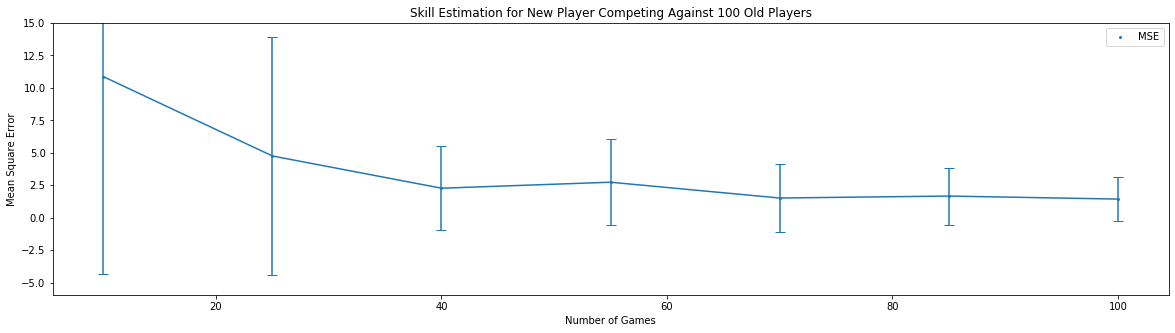

In [55]:
plt.figure(figsize=(20,5))
x = []
y = []
std = []

for key in result:
    x.append(key)
    y.append(np.mean(result[key]))
    std.append(np.std(result[key]))

print(x)
print(y)
plt.scatter(x, y, marker='.' ,label = 'MSE',linewidths=0.01)
plt.errorbar(x, y, yerr = std, capsize = 5)

plt.title('Skill Estimation for New Player Competing Against 100 Old Players')
plt.xlabel('Number of Games')
plt.ylabel('Mean Square Error')
plt.ylim(top=15)
plt.legend()
plt.show()